In [1]:
import sys

sys.path.append('../src')

In [2]:
import numpy as np
import pcalg
import networkx as nx
from conditional_independence import partial_correlation_suffstat, partial_correlation_test
from mcmc.mcmc import PartitionMCMC
from mcmc.data import SyntheticDataset
from mcmc.proposals import PartitionProposal
from mcmc.scores import BGeScore

In [3]:
num_nodes = 6
node_labels = [chr(ord('a') + i) for i in range(num_nodes)]
num_obs = 200
degree = 3

synthetic_data = SyntheticDataset(num_nodes=num_nodes, num_obs=num_obs, node_labels=node_labels, degree=degree)

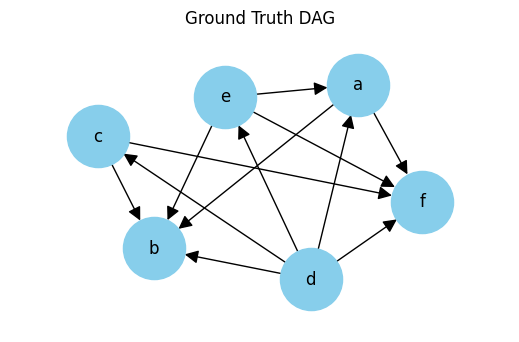

In [4]:
# visualise ground truth DAG
from mcmc.utils.graph_utils import plot_graph_from_adj_mat
plot_graph_from_adj_mat(synthetic_data.adj_mat.values, node_labels, title="Ground Truth DAG")

In [5]:
synthetic_data.data

,a,b,c,d,e,f
0,-1.155065,1.667495,1.367541,-0.967700,0.145449,3.157627
1,2.283457,0.835855,-2.159955,1.033248,-1.032182,-4.813644
2,3.871730,-6.036146,-4.881317,2.535478,-0.102324,-10.334343
3,0.993218,2.526201,1.371528,-0.290977,0.309039,7.651057
4,0.960822,3.566270,0.260759,0.253482,-1.108905,1.242768
...,...,...,...,...,...,...
195,2.433348,-0.864483,-2.861313,0.631916,-0.834217,-6.052551
196,-1.911555,1.830448,2.165375,-1.215323,1.495242,7.015834
197,-5.897820,-2.118550,3.852629,-1.281633,3.739142,4.954372
198,1.811536,1.835583,0.446043,0.536739,-0.892448,0.919220


In [6]:
# setup mcmc
M = PartitionMCMC(max_iter=10000, data=synthetic_data.data, score_object='bge')

Running PC algorithm


In [7]:
# run experiment

mcmc_results, acceptance = M.run()
graphs = M.get_mcmc_res_graphs(mcmc_results)
print('Acceptance_ratio:', acceptance)

Acceptance_ratio: 0.0599


In [9]:
from mcmc.utils.graph_utils import generate_key_from_adj_matrix

BURN_IN = 0.1

graphs = M.get_mcmc_res_graphs(mcmc_results)

key = generate_key_from_adj_matrix(synthetic_data.adj_mat.values)
keys, counts = np.unique([generate_key_from_adj_matrix(g) for g in graphs[int(BURN_IN*len(graphs)):]], return_counts=True)
print(key in keys)

False


IndexError: index 0 is out of bounds for axis 0 with size 0

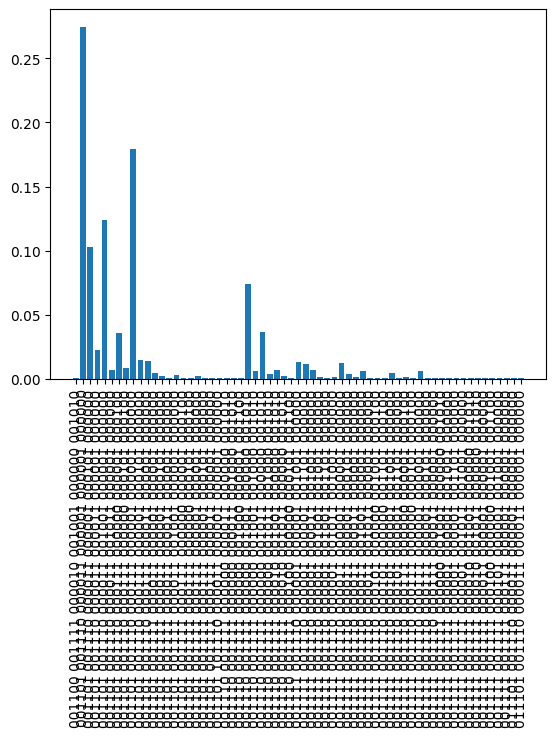

In [10]:
from matplotlib import pyplot as plt

bars = plt.bar(range(len(keys)), counts/sum(counts))
plt.xticks(range(len(keys)), keys, rotation=90);
bars[np.where(keys==key)[0][0]].set_color('red')

-1739.6466350302323


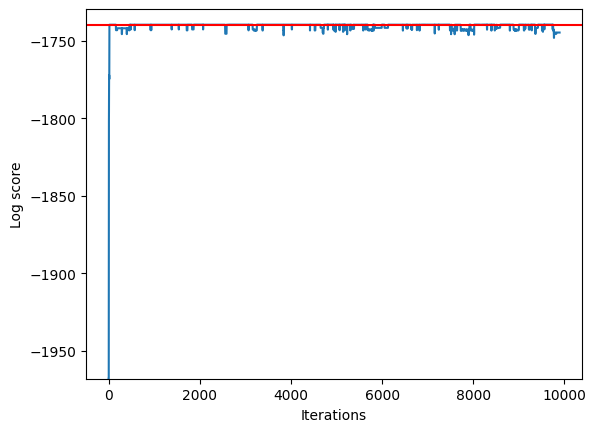

In [10]:
from mcmc.utils.partition_utils import convert_partition_to_party_permy_posy
from mcmc.utils.score_utils import partition_score

def get_mcmc_scores(results):
        mcmc_graph_lst = []
        for i in results:
            mcmc_graph_lst.append( results[i]['score_P_curr'] )
        return mcmc_graph_lst
scores = get_mcmc_scores(mcmc_results)

true_partition = build_partition(incidence=synthetic_data.adj_mat.values, node_labels=list(synthetic_data.data.columns))
party_curr, permy_curr, posy_curr = convert_partition_to_party_permy_posy(true_partition)
true_score = partition_score(M.node_labels, M.node_labels, M.parent_table, M.score_table, permy_curr, party_curr, posy_curr )
true_score = sum(true_score['total_scores'].values())
plt.plot(range(len(scores)), scores)
plt.axhline(true_score, color='r')
plt.ylim(min(scores), true_score+10)
plt.xlabel('Iterations')
plt.ylabel('Log score')
print(true_score)

In [11]:
from mcmc.evaluation.metrics import kl_divergence, jensen_shannon_divergence, mean_squared_error, mean_absolute_error
from mcmc.inference.posterior import generate_all_dags_keys, generate_all_dags

all_dags = generate_all_dags(data=synthetic_data.data, my_score=BGeScore)


KeyboardInterrupt: 

In [ ]:

from mcmc.inference.posterior import compute_true_distribution

true_distribution = compute_true_distribution(all_dags)
dst = {key:count/sum(counts) for key, count in zip(keys, counts)}
approx_distribution = {key: (dst[key] if key in dst else 0) for key in true_distribution.keys()}

threshold = 1e-5
k = list(true_distribution.keys())
for _k in k:
    if true_distribution[_k] < threshold and approx_distribution[_k] < threshold:
        del true_distribution[_k]
        del approx_distribution[_k]
k = np.array(list(true_distribution.keys()))
bars = plt.bar(k, true_distribution.values())
# print(k, key)
bars[np.where(k==key)[0][0]].set_color('red')
plt.figure()
bars = plt.bar(approx_distribution.keys(), approx_distribution.values())
bars[np.where(k==key)[0][0]].set_color('red')

In [ ]:
from mcmc.evaluation.metrics import mean_squared_error, mean_absolute_error, kl_divergence, jensen_shannon_divergence

print('KL div', kl_divergence(true_distribution, approx_distribution))
print('JS div', jensen_shannon_divergence(true_distribution, approx_distribution))
print('MSE', mean_squared_error(true_distribution, approx_distribution))
print('MAE', mean_absolute_error(true_distribution, approx_distribution))

In [12]:
import numpy as np
import pandas as pd
from mcmc.mcmc import PartitionMCMC
from mcmc.proposals import PartitionProposal
from mcmc.scores import BGeScore
from mcmc.utils.partition_utils import build_partition

from mcmc.data import SyntheticDataset
np.random.seed(1)
n_iterations = 100000
n_nodes = 3
seed = 1

N = 100
node_labels = ('x', 'y', 'z')
data = np.zeros((N, n_nodes))
data[:, 0] = np.random.normal(0, 1, 100)
data[:, 1] = data[:, 0] + np.random.normal(0, 1, 100)
data[:, 2] = data[:, 0] + np.random.normal(0, 1, 100)
data = pd.DataFrame(data, columns = node_labels)

# start with a random initial graph
initial_graph = np.random.choice([0,1], size=(n_nodes, n_nodes))*np.tri(n_nodes, n_nodes, -1)
p = np.random.permutation(n_nodes)
initial_graph = initial_graph[p, :]
initial_graph = initial_graph[:, p]

# create score and proposal objects
score = BGeScore(data, initial_graph)
initial_partition = build_partition(incidence=initial_graph, node_labels=node_labels)
proposal = PartitionProposal(initial_partition)

# initialise structure MCMC
M = PartitionMCMC(initial_partition, n_iterations, proposal, score)

# run MCMC
mcmc_results, acceptance = M.run()

# get chain of graphs
graphs = M.get_mcmc_res_graphs(mcmc_results)


key = generate_key_from_adj_matrix(synthetic_data.adj_mat.values)
keys, counts = np.unique([generate_key_from_adj_matrix(g) for g in graphs[int(BURN_IN*len(graphs)):]], return_counts=True)

Initialise:  0.00000


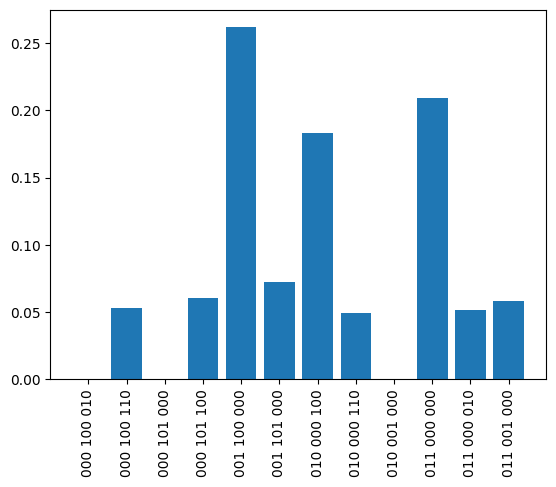

In [13]:
bars = plt.bar(range(len(keys)), counts/sum(counts))
plt.xticks(range(len(keys)), keys, rotation=90);